In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy as sp
import numpy as np
import control as ctl
import random

# OBTENDO DADOS

In [70]:
df = pd.read_csv('DataBase.csv')
df['output'] = df.output - df.output[:5].mean()
print('size:', len(df))
df.head()

size: 274


,time,input,output
0,0.00,135,0.008
1,0.00,135,-0.012
2,0.01,135,0.008
3,0.01,135,0.008
4,0.01,135,-0.012


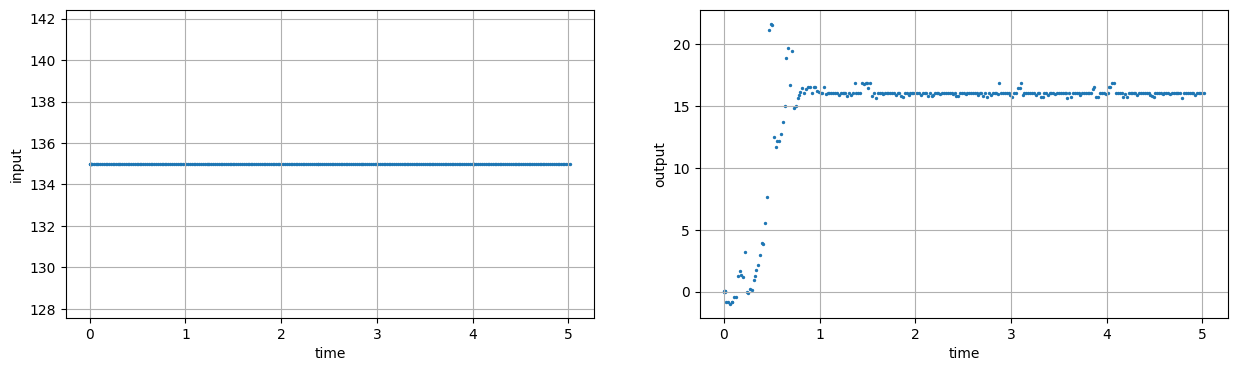

In [71]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.scatter(df.time, df.input, s=2)
plt.xlabel('time'), plt.ylabel('input')
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(df.time, df.output, s=2)
plt.xlabel('time'), plt.ylabel('output')
plt.grid()

In [72]:
df = df.loc[(df.time < 0.7) & (df.output < 20)]

# PADRONIZANDO OS DADOS

In [73]:
def normalizeData(df, timeKey, responseKey, T=0.15):
    initTime  = df[timeKey].iloc[0]
    finalTime = df[timeKey].iloc[-1] + T
    timeData = np.arange(initTime, finalTime, T)
    
    lastValue  = df[responseKey].iloc[0]
    desired = []

    for t in timeData:
        filtered = df.loc[df[timeKey] <= t][responseKey]
        
        if not filtered.empty:
            lastValue = filtered.iloc[-1]
        
        desired.append(lastValue)
    
    return timeData, desired


def normalizeTable(df, key, T=0.15):
    table = {key: []}

    for column in df.columns:
        if column == key:
            continue

        xData, yData = normalizeData(df, key, column, T)
        table[column] = yData

    table[key] = xData
    return pd.DataFrame(table) 


T = 0.01
df = normalizeTable(df, 'time', T)
print('size:', len(df))
df.head()

size: 70


,time,input,output
0,0.00,135,-0.012
1,0.01,135,-0.012
2,0.02,135,-0.872
3,0.03,135,-0.872
4,0.04,135,-0.872


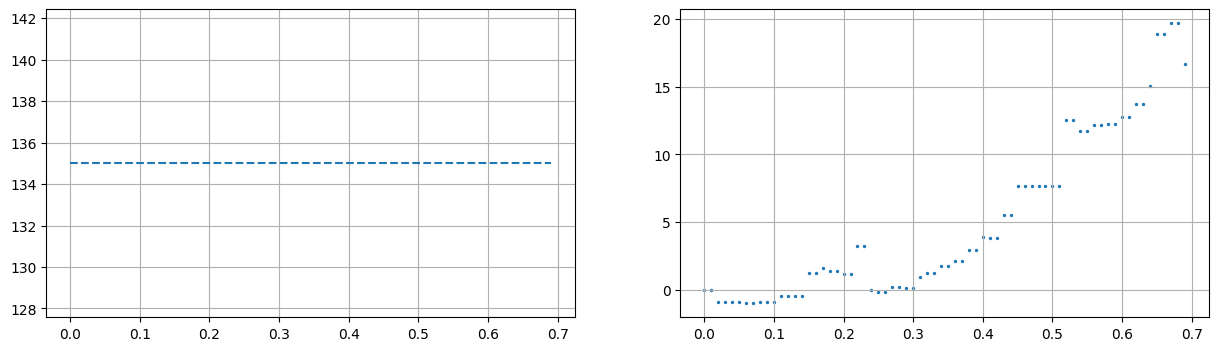

In [74]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(df.time, df.input, '--')
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(df.time, df.output, s=2)
plt.grid()

In [75]:
tData, uData, yData = df.time.values, df.input.values, df.output.values

# DATA FITTING
O gráfico expressa a função de transferência no domínio do tempo $Y(s) = L^{-1}\{y(t)\}$, podemos encontrar $y(t)$ usando data fitting, encontrando uma função própria que se encaixe nos dados

In [76]:
tData, uData, yData = df.time.values, df.input.values, df.output.values

In [77]:
def g(u, a, b):
    s = ctl.TransferFunction.s
    G = a/(s + b)
    return ctl.forced_response(G, T=tData, U=u)[1]

def getFunction(xDados, yDados):
    coeficientes = curve_fit(g, xDados, yDados, maxfev=1000000000)  # MÁXIMO DE ITERAÇÕES
    return list(coeficientes[0])

In [78]:
coefs = getFunction(uData, yData)  
coefs

[0.02528749013925116, -5.004437985492975]

In [79]:
s = ctl.TransferFunction.s
a, b = coefs

G = a/(s + b)
G

TransferFunction(array([0.02528749]), array([ 1.        , -5.00443799]))

### CONFERINDO COM A DATABASE

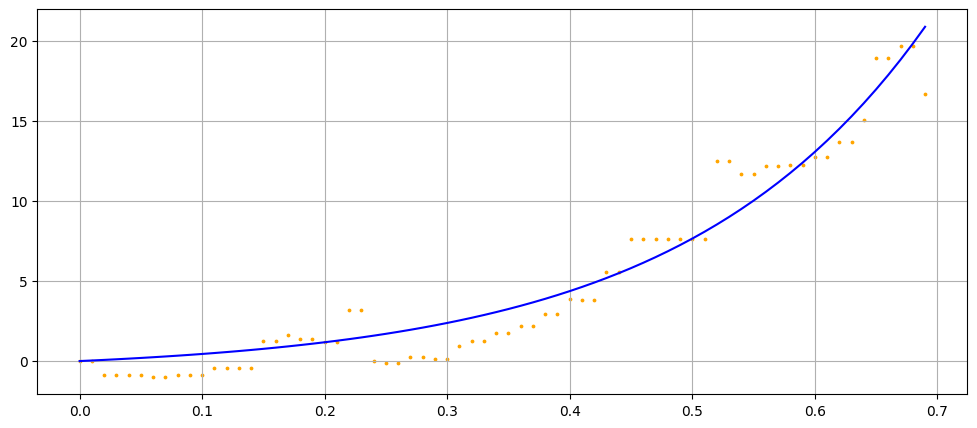

In [80]:
time, response = ctl.forced_response(G, T=tData, U=uData)

plt.figure(figsize=(12, 5))
plt.plot(time, response, color='blue')
plt.scatter(time, yData, color='orange', s=3)
plt.grid()

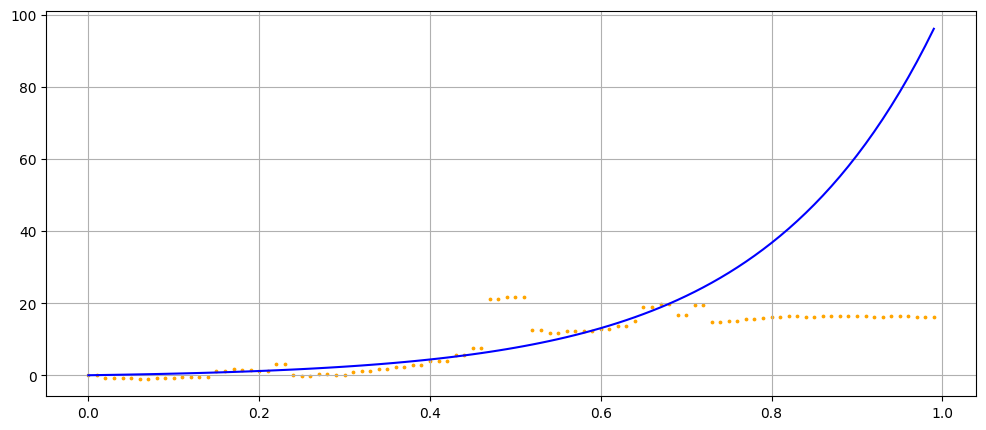

In [81]:
df = pd.read_csv('DataBase.csv')
df['output'] = df.output - df.output[:5].mean()

df = normalizeTable(df, 'time', T)
df = df.loc[df.time < 1]

time, response = ctl.forced_response(G, T=df.time, U=df.input)
plt.figure(figsize=(12, 5))
plt.plot(time, response, color='blue')
plt.scatter(df.time, df.output, color='orange', s=3)
plt.grid()

In [82]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=4):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

print(roundSympyFunction(sympyFunction(G)))

0.0253/(1.0*s - 5.0044)
